In [1]:
#! pip install gymnasium[classic_control]

In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical

torch.autograd.set_detect_anomaly(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device:", device)

Using Device: cuda


In [2]:
# Utility Functions
def transformState(S_t):
    return [ math.atan2( S_t[0], S_t[1]), math.atan2( S_t[2], S_t[3]), S_t[4], S_t[5] ]

def select_action_from_policy(model, S_t):
    S_t = torch.from_numpy(S_t).float().unsqueeze(0).to(device)
    probs = model(S_t)
    m = Categorical(probs)
    A_t = m.sample()
    return A_t.item(), m.log_prob(A_t)

In [3]:
class PolicyGradientNN(nn.Module):
    def __init__(self, input_length, output_length):
        super(PolicyGradientNN, self).__init__()
        self.L1 = nn.Linear(input_length, 128)
        self.L2 = nn.Linear(128,128)
        self.L3 = nn.Linear(128, output_length)
        
    def forward(self,x):
        x = self.L1(x)
        x = F.relu(x)
        x = self.L2(x)
        x = F.relu(x)
        x = self.L3(x)
        x = F.relu(x)
        
        return F.softmax(x, dim=1)

In [4]:
env = gym.make("Acrobot-v1")

In [5]:
input_length, output_length = 4, 3
lr = 0.02
Gamma = 0.95

model = PolicyGradientNN(input_length, output_length).to(device)
optimizer = optim.RMSprop(model.parameters(), lr)
rewards_per_episode = []
history_per_episode = []
max_episodes = 1000
for i in range(max_episodes):

    # Perform an Episode
    episodeRewards = []
    episodeActions = []
    episodeStates = []
    episodeLogProb = []
    history = 0
    
    S_t = env.reset(seed = random.randint(0,100))[0]
    S_t = np.array(transformState(S_t))
    A_t, logprob = select_action_from_policy(model, S_t)
    
    for t in range(1000):

        stepData = env.step(A_t)
        observations, reward, terminated, truncated, info = stepData[0], stepData[1], stepData[2], stepData[3], stepData[4]
        
        R_t = reward

        episodeRewards.append(R_t)
        episodeActions.append(A_t)
        episodeStates.append(S_t)
        episodeLogProb.append(logprob.to(device))

        S_t = transformState(observations)
        S_t = np.array(S_t)
        A_t, logprob = select_action_from_policy(model, S_t)
        
        if terminated:
            break

    # Update Policy
    T = len(episodeRewards)
    # print("Episode Lenght:",T)
    # print("Episode Reward:",episodeRewards)
    # print("Episode Actions:",episodeActions)
    # print("Episode States:",episodeStates)
    # print("Episode Log Props:",episodeLogProb)

    loss = 0
    loss_per_step = []
    for t in range(0, T): # from 0 to T-1
        G = 0
        for k in range(t+1,T+1): # from t+1 to T
            G += (Gamma**(k-t-1))*episodeRewards[k-1] # should be R1 but we're using zero indexing for R
        # loss_per_step.append(-(Gamma**t)*episodeLogProb[t]*G)
        loss -= (Gamma**t)*episodeLogProb[t]*G
    # for t in range(0, T): # from 0 to T-1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    rewards_per_episode.append(sum(episodeRewards))
    history = T
    history_per_episode.append(history)
    print("Episode: ", i, "\tHistory: ", history, "\tLoss:", loss.item(), "\tReward:", sum(episodeRewards))


    
    # Add data for Visulaization
    

Episode:  0 	History:  1000 	Loss: -439.50701904296875 	Reward: -1000.0
Episode:  1 	History:  1000 	Loss: -4.768369399243966e-05 	Reward: -1000.0
Episode:  2 	History:  1000 	Loss: -4.768369399243966e-05 	Reward: -1000.0


KeyboardInterrupt: 

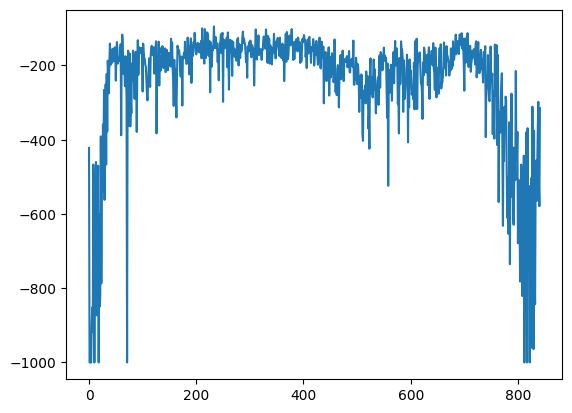

In [ ]:
plt.figure()
plt.plot(rewards_per_episode)
plt.show()

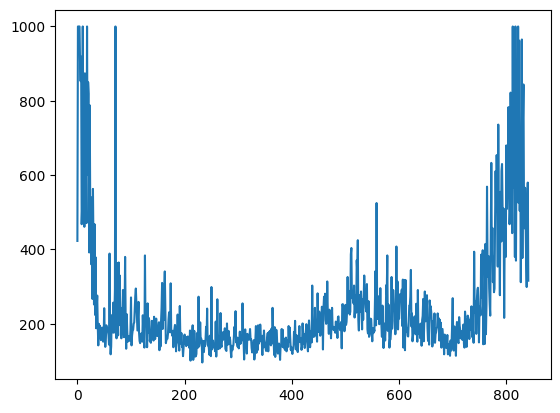

In [ ]:
plt.figure()
plt.plot(history_per_episode)
plt.show()